# Mini-Projet 4 #

In [2]:
#Pour les imports diverses :

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

### 1.Étude du problème d'otpimisation ###

1. Soit $$f : z \mapsto \frac{1}{2} || z - z_b ||_2^2 + \sum_{(i,j)}|| \nabla z(i,j)||_2^2$$

$f$ est la fonction coût à minimiser par rapport à l'image bruitée $z_b$.\
Les variables de décisions sont les coordonnées de la matrice $z$, au nombre de $n \times m$.

Tous les pixels devant en outre être compris entre $0$ et $1$, le vecteur contrainte $c(z)$ contient l'ensemble des coordonnées de $z$ avec $$\forall (i,j) \in \mathbb{R}^{n}\times \mathbb{R}^{m} c_{i,j}= u_{i,j}-1 \text{ et } c_{n+i,m+j}=-u_{i,j}$$
Il y a donc $2\times n\times m=2nm$ contraintes. 

2. f est convexe et différentiable comme la somme et la composition de fonctions quadratiques en les coordonnées de $u$ et différentiables (polynomiales en les coefficients de $u$). 

3. Montrons que $$ \nabla f  = u - u_b - 2\text{div}(\nabla u) = u - u_b - 2\Delta u$$

On a d'abord $||u+h||_2^2=||u||_2^2+||h||^2_2+2<u,h>$ donc par identification $\nabla(||u||_2^2)=2u$.

Par ailleurs, posons $g(u)=<\nabla ^d u,\nabla ^d u >$.

On a $g(u+h)= g(u) + 2 <\nabla ^d u,\nabla ^d h >_{\mathbb{R}^{2\times n\times m }} + o(h^2)$ 

D'où $\text{d}g_u(h)=2<\nabla ^d u,\nabla ^d h >=2<\nabla ^{d*} \nabla ^d u, h >$ avec $\nabla ^{d*}$ désignant l'adjoint de $\nabla ^d$, le gradient discret. On va montrer que cet adjoint est en réalité l'opérateur divergente, ce qui nous donnera : $$\nabla g = 2 \times \text{div} (\nabla ^d u)$$

Montrons donc que : $$\forall (u,v) \in \mathbb{R}^{n\times m }\times \mathbb{R}^{2\times n \times m} <\nabla ^d u, v>_\mathbb{R}^{2\times n \times m} = <u, \text{div} (v)>_\mathbb{R}^{n\times m}$$

$\text{\red{À COMPLÉTER}}$



### 2. Résolution numérique ###

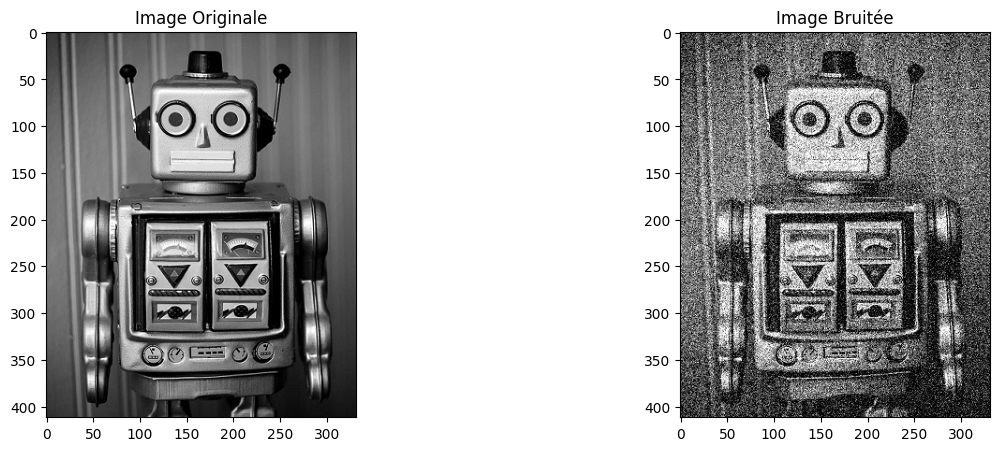

In [4]:
#Pour les questions 4 à 7

imgR0 = plt.imread("robot_no_noise.jpg")
imgR = imgR0[:, :, 0] / 255
imgRB0 = plt.imread("robot_noise.jpg")
imgRB = imgRB0[:, :, 0] / 255


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(imgR,cmap='gray')
axes[0].set_title("Image Originale")
axes[1].imshow(imgRB,cmap='gray')
axes[1].set_title("Image Bruitée")
plt.show();

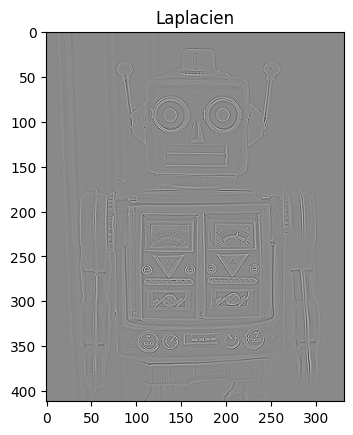

In [7]:
#Question 4

def grad(u):
    dux = np.zeros(u.shape)
    duy = np.zeros(u.shape)

    dux[:-1, :] = u[1:, :] - u[:-1, :]
    duy[:, :-1] = u[:, 1:] - u[:, :-1]

    return np.array([dux, duy])


def div(v):
    n, m = v.shape[1], v.shape[2]
    divx = np.zeros((n, m))
    divy = np.zeros((n, m))

    divx[1:, :] = v[0, 1:, :] - v[0, :-1, :]
    divx[0, :] = v[0, 0, :]
    divx[-1, :] = -v[0, -2, :]

    divy[:, 1:] = v[1, :, 1:] - v[1, :, :-1]
    divy[:, 0] = v[1, :, 0]
    divy[:, -1] = -v[1, :, -2]

    return divx + divy


def laplacien(u):
    return div(grad(u))


plt.imshow(laplacien(imgR),cmap='gray')
plt.title("Laplacien")
plt.show();

5. Choix des paramètres et commentaire de l'image :

    L'image initiale choisie est une entièrement blanche (tous les pixels à 0). Le pas est pris à $10^{-2}$, et la condition d'arrêt égale à un nombre maximal d'itérations de 100.\
    En effet, il le fallait supérieur à $10^{-3}$ pour être certain d'éviter les effets d'arrondi sur python, qui fausseraient le résultat. Pour un pas de $10^{-3}$, l'image était trop proche de celle bruitée, au point de retranscrire le bruit ; un pas plus grand permet ainsi un meilleur lissage. De plus, un pas de $5.10^{-2}$ lisse trop l'image et donne une impression de "flou".

    En augmentant le nombre d'itérations, le temps d'exécution de la méthode augmente significativement, sans que l'image ne paraisse beaucoup changer. Il est donc préférable de "jouer" sur le pas pour améliorer la netteté et le lissage de l'image.

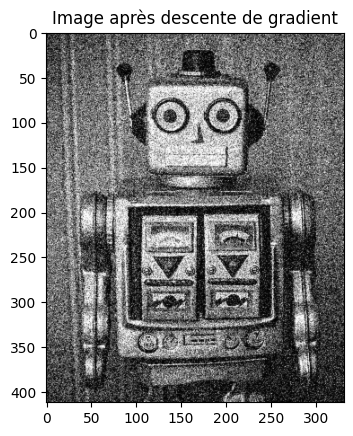

In [ ]:
## Q5 Méthode de descente de gradient à pas fixe


def funR(u, ub):
    g = grad(u)
    return (
        (np.linalg.norm(u - ub, ord=2) ** 2) / 2
        + np.linalg.norm(g[0], ord=2) ** 2
        + np.linalg.norm(g[1], ord=2) ** 2
    )


def grad_funR(u, ub):
    return u - ub - 2 * laplacien(u)


def optim_gradient_fixed_step(grad_fun, x0, L, xb, max_iter=100, epsilon_grad_fun=1e-9):
    nb_iter = 0
    x = x0
    while nb_iter <= max_iter and np.linalg.norm(grad_fun(x, xb)) > epsilon_grad_fun:
        nb_iter += 1
        x -= L * grad_fun(x, xb)
    return x


x0, pas = np.zeros(imgR.shape), 1e-2
imgRB_opti = optim_gradient_fixed_step(grad_funR, x0, pas, imgRB)

plt.imshow(imgRB_opti, cmap="gray")
plt.title("Image après descente de gradient")
plt.show();

In [9]:
# test pour vérifier les implémentations des fonctions précédentes

def approx_grad_funR(x, xb, eps, h):
    return (funR(x + eps * h, xb) - funR(x - eps * h, xb)) / (2 * eps)

u = np.random.random(imgRB.shape)
eps = 10 ** (-5)
h = np.random.random(imgRB.shape)
h = h/np.linalg.norm(h)
print(approx_grad_funR(u, imgRB, eps, h) - np.dot(np.transpose(grad_funR(u, imgRB)).ravel(), h.ravel()))

1.7795571258276794


In [10]:
# Question 6

def RMSE(u, uVT):
    n, m = u.shape
    return np.linalg.norm(uVT - u) / (n * m) ** 0.5


print(
    f"RMSE de l'image trouvée par minimisation = {RMSE(imgRB_opti, imgR):.5f}, et RMSE de l'image bruitée = {RMSE(imgRB, imgR):.5f}"
)

RMSE de l'image trouvée par minimisation = 0.41200, et RMSE de l'image bruitée = 0.18528


7. L'image est très ressemblante à celle de la méthode de descente de gradient implémentée précédemment. Cela permet de confirmer les choix d'image initiale et de pas fixe dans la méthode précédente.

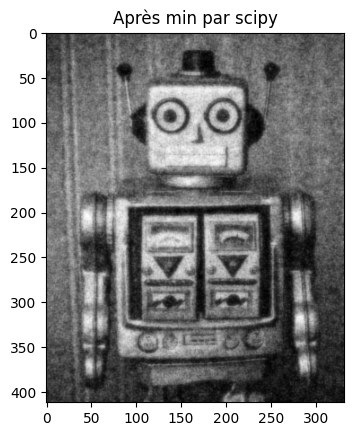

In [11]:
def funR_vect(u):
    v = u.reshape(imgRB.shape)
    g = grad(v)
    return (
        (np.linalg.norm(v - imgRB) ** 2) / 2
        + np.linalg.norm(g[0])
        + np.linalg.norm(g[1])
    )


def grad_funR_vect(u):
    v = u.reshape(imgRB.shape)
    g = v - imgRB - 2 * laplacien(v)
    return g.flatten()


def scipy_opti(fun, grad_fun, x0):
    sol = optimize.minimize(
        fun, x0.flatten(), jac=grad_fun, method="CG"
    ).x  # ou L-BFGS-B
    return sol.reshape(x0.shape)


plt.imshow(scipy_opti(funR_vect, grad_funR_vect, x0), cmap="gray")
plt.title("Après min par scipy")
plt.show();

### 3. Étude d'une nouvelle fonction TV-L2 ###

8.  Soit $$f : z \mapsto \frac{1}{2} || z - z_b ||_2^2 + \sum_{(i,j)}|| \nabla z(i,j)||_1$$
La fonction est toujours convexe comme somme d'une fonction quadratique en les coordonnées de $u$ et de la fonction valeur absolue appliquée à des combinaisons linéaires des coordonnées de $u$. En dehors des points où le gradient de $u$ s'annule en au moins une coordonnée, elle est différentiable car polynomiale en les coordonnées de $u$.


9. Soit $u $ un point de $\mathbb{R}^{n\times m}$ tel que son gradient discret ne comporte aucune coordonnée nulle. f est différentiable en ce point.\
Comme précédemment, le gradient de $\frac{1}{2} || u- u_b ||_2^2$ est $u-u_b$.

$\text{\red{À IGNORER POUR LE MOMENT}}$ 
On a $$\nabla (\sum_{(i,j)}|| \nabla u(i,j)||_1)(i,j)=\frac{\partial \biggl(|\nabla _x u(i,j)| +|\nabla _y u(i,j)|\biggl ) }{\partial u_{i,j}}$$
car seuls ces termes ont une dépendance en $u_{i,j}$
$$=\frac{\partial \biggl (\text{sg}(\nabla _x u(i,j))\times \nabla _x u(i,j) + \text{sg}(\nabla _y u(i,j))\times \nabla _y u(i,j)\biggl)}{\partial u_{i,j}}$$

$$=\frac{\partial \biggl(\text{sg}(\nabla _x u(i,j))\times (u(i+1,j)-u(i,j)) + \text{sg}(\nabla _y u(i,j))\times (u(i,j+1)-u(i,j))\biggl )}{\partial u_{i,j}}$$

$$=-\biggl(\text{sg}(\nabla _x u(i,j)) + \text{sg}(\nabla _y u(i,j))\biggl)$$


Par ailleurs, $\nabla u$ est une matrice de taille $n\times m$ donc il est en de même pour $\text{sg}(\nabla u)$. \
Par conséquent, on a $\text{sg}(\text{div})$

$\text{\red{FIN DU À IGNORER}}$ 

Posons $g(u)=||\nabla (u)||_1$

On a $$g(u+h)=||\nabla (u) +\nabla (h)||_1=|| \nabla u||_1 + <\text{sg}(\nabla (u)), \nabla (h)> +o(h) $$ car la différentielle de la norme $1$ appliquée en un vecteur $u$ est égale au signe de $u$. 

D'où par la question $3$, on a $$g(u+h)= || \nabla u||_1 + <\text{div} (\text{sg}(\nabla (u))), h>$$
Par identification, $\nabla g(u) = \text{div} (\text{sg}(\nabla (u))$\
On en déduit donc que pour les vecteurs $u$ ne comportant aucune composante nulle, on a bien $$\nabla f = u - u_b - \text{div} (\text{sg}(\nabla (u)))$$



En un point $u$ de $\mathbb{R}^{nm}$ on pose $g(u) = u - u_b - \text{div} (\text{sg}(\nabla (u)))$. 
On va montrer que $g(u)$ est dans le sous-différentiel de $f$ en $u$, et l'on se servira de la caractérisation $$\partial f(u) = \text{Conv}\biggl(\{ \lim _{i\rightarrow + \infty } \nabla f(u_i) | u_i \rightarrow u, u_i \notin \Omega_f \}\biggl)$$ avec $\Omega_f$ l'ensemble des points dans un voisinage de $u$ où $f$ n'est pas différentiable et Conv l'enveloppe convexe de cet ensemble.


On prend maintenant une perturbation $\epsilon > 0$ telle que $\epsilon < 2\times \text{inf} (u_{ij})$, afin de ne pas rendre nulles des composantes de $u$ qui ne l'étaient pas. 
On considère la matrice $M$ : 

$$ M= \epsilon \times \begin{pmatrix}
1 & 2 & ... & m\\
2 & 3 & ... & m+1\\
...&...&...&...\\
...&...&...&...\\
n & n+1 & ... & n+m\\
\end{pmatrix}$$

Le gradient discret de $M$ vaut 
$$ \nabla M= \epsilon \times \begin{pmatrix}
2 & 2 & ... &2 & 1\\
2 & 2 & ... & 2 & 1\\
2&...&...&... & 1\\
...&...&...&...\\
2&...&...&2& 1\\
1 &1 & ... & 1 & 1\\
\end{pmatrix}$$


On calcule $f(u+\epsilon M)$ et $f(u-\epsilon M)$ : toutes les composantes nulles dans les valeurs absolues ne le sont plus, leur signe est $1$ dans le premier cas et $-1$ dans le deuxième (f est linéaire en les coefficients de $u$).

Les valeurs non nulles ne le deviennent pas grâce aux choix de $\epsilon$.

En faisant tendre $\epsilon$ vers 0, on trouve que les matrices comportant des $1$ et des $-1$ en place de $0$ dans les valeurs absolues sont dans le sous-différentiel de $f$ : comme celui-ci est une enveloppe convexe, la valeur $0 \in [-1,1]$ en ces coordonnées est acceptable.
On a tendu vers la valeur de $g(u)$ par valeurs supérieures et par valeurs inférieures.\
Par conséquent $g(u)$ est bien un sous-vecteur. 






10. Choix des paramètres et commentaire de l'image:
    
    L'image initiale et la condition d'arrêt sont identiques à ceux de la méthode précédente, pour les mêmes raisons.\
    Le pas est choisi un peu plus grand $=5.10^{-2}$, car la nouvelle fonction à optimiser a un effet de lissage plus important, et rend donc une image plus "floue" pour un même pas.
    
    $\text{\red{A COMPLETER RSME}}$

RMSE de l'image trouvée par minimisation de TV-L2 = 0.2058, et RMSE de l'image bruitée = 0.1853


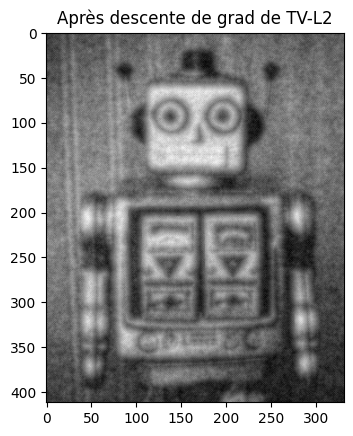

In [ ]:
def grad_TVL2(u, ub):
    return u - ub - div(np.sign(grad(u)))


x0, pas, m_iter = np.zeros(imgR.shape), 5e-2, 100
imgRB_opti_TVL2 = optim_gradient_fixed_step(grad_TVL2, x0, pas, imgRB, m_iter)

plt.imshow(imgRB_opti_TVL2, cmap="gray")
plt.title("Après descente de grad de TV-L2")

print(
    f"RMSE de l'image trouvée par minimisation de TV-L2 = {RMSE(imgRB_opti_TVL2, imgR):.4f}, et RMSE de l'image bruitée = {RMSE(imgRB, imgR):.4f}"
)

plt.show();

In [ ]:
# Vérification du gradient

def TVL2(u, ub):
    g = grad(u)
    return (
        (np.linalg.norm(u - ub, ord=2) ** 2) / 2
        + np.linalg.norm(g[0], ord=1)
        + np.linalg.norm(g[1], ord=1)
    )

def approx_grad_TVL2(x, xb, eps, h):
    return (TVL2(x + eps * h, xb) - TVL2(x - eps * h, xb)) / (2 * eps)

u = np.random.random(imgRB.shape)
eps = 10 ** (-5)
h = np.random.random(imgRB.shape)
h = h / np.linalg.norm(h)
print(
    approx_grad_TVL2(u, imgRB, eps, h)
    - np.dot(np.transpose(grad_TVL2(u, imgRB)).ravel(), h.ravel())
)

-0.30783651648549437


11. Choix des paramètres et commentaire :

    La méthode avec ajout de momentum augmente encore l'effet de lissage. Comme précédemment, le seul paramètre qu'on modifie est le pas, qu'on augmente ici jusqu'à $0.1$.

    "A COMPLETER"

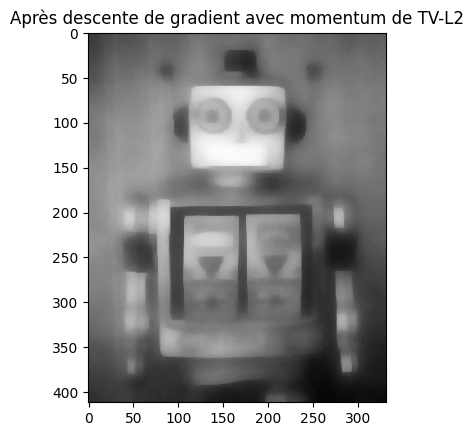

In [ ]:
beta = 0.9

def optim_gradient_momentum(grad_fun, x0, L, xb, max_iter=100, epsilon_grad_fun=1e-8):
    global beta
    nb_iter = 0
    x = x0
    p = -grad_fun(x, xb)
    while nb_iter <= max_iter and np.linalg.norm(grad_fun(x, xb)) > epsilon_grad_fun:
        nb_iter += 1
        p = beta * p + (1 - beta) * (-grad_fun(x, xb))
        x += L * p
    return x

x0, pas, m_iter = np.zeros(imgR.shape), 1e-1, 100
imgRB_opti_TVL2_mom = optim_gradient_momentum(grad_TVL2, x0, pas, imgRB, m_iter)

plt.imshow(imgRB_opti_TVL2_mom, cmap="gray")
plt.title("Après descente de gradient avec momentum de TV-L2")

plt.show();

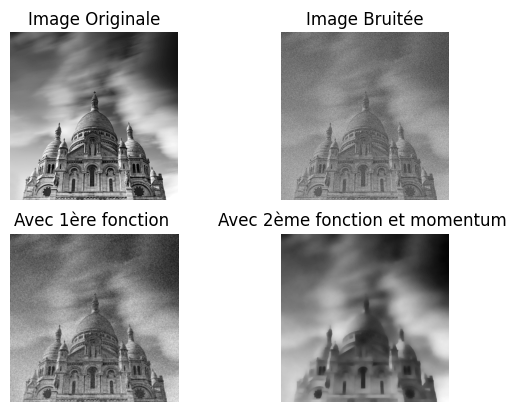

In [18]:
imgM0 = plt.imread("montmartre_no_noise.jpg")
imgM = imgM0[:, :, 0] / 255
imgMB = np.random.normal(loc=imgM, scale=0.2)

fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(imgM, cmap="gray")
axes[0,0].set_title("Image Originale") 
axes[0,0].axis('off') 
axes[0,1].imshow(imgMB, cmap="gray") 
axes[0,1].set_title("Image Bruitée") 
axes[0,1].axis('off') 

x0M, pasM, m_iterM = np.zeros(imgM.shape), 1e-2, 100 

# Méthode de descente de gradient à pas fixe avec la 1ère fonction 

imgMB_opti = optim_gradient_fixed_step(grad_funR, x0M, pasM, imgMB, m_iterM) 
axes[1,0].imshow(imgMB_opti, cmap= "gray") 
axes[1,0].set_title( "Avec 1ère fonction ") 
axes[1,0].axis('off') 

# Méthode de descente de gradient à pas fixe, avec momentum, avec la 2ème fonction 

pasM2 = 1e-1 
imgMB_opti_TVL2_mom = optim_gradient_momentum(grad_TVL2, x0M, pasM, imgMB, m_iterM) 
axes[1,1].imshow(imgMB_opti_TVL2_mom, cmap= "gray") 
axes[1,1].set_title( "Avec 2ème fonction et momentum ")
axes[1,1].axis('off') 

plt.show();